In [9]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

all_data = {ticker: web.get_data_yahoo(ticker) for ticker in ['SPY', 'QQQ', 'XLF']}

spy_df = all_data['SPY']
qqq_df = all_data['QQQ']
xlf_df = all_data['XLF']


In [45]:
def volatility(df):
    return (df['High']- df['Low']) / df['Close']

def _delta(df):
    volume_delta = df['Volume'] - df['Volume'].shift(1)
    volat_delta = df['Volatility'] - df['Volatility'].shift(1)
    return volume_delta, volat_delta



spy_df['Volatility'] = volatility(spy_df)
qqq_df['Volatility'] = volatility(qqq_df)
xlf_df['Volatility'] = volatility(xlf_df)


spy_volume_delta, spy_vola_delta = _delta(spy_df)
spy_df['Volume_Delta'] = spy_volume_delta
spy_df['Volatility_Delta'] = spy_vola_delta


qqq_volume_delta, qqq_vola_delta = _delta(qqq_df)
qqq_df['Volume_Delta'] = qqq_volume_delta
qqq_df['Volatility_Delta'] = qqq_vola_delta


xlf_volume_delta, xlf_vola_delta = _delta(xlf_df)
xlf_df['Volume_Delta'] = xlf_volume_delta
xlf_df['Volatility_Delta'] = xlf_vola_delta

In [31]:
vola_df = pd.DataFrame({'SPY': spy_df['Volatility'], 'QQQ': qqq_df['Volatility'], 'XLF': xlf_df['Volatility']})

In [38]:
vola_df.corr()

,SPY,QQQ,XLF
SPY,1.000000,0.925947,0.891894
QQQ,0.925947,1.000000,0.826294
XLF,0.891894,0.826294,1.000000


From the correlation we can see that QQQ and XLF have a fairly strong correlation with SPY and less so between each other. QQQ does have a slightly stronger correlation but only slight.

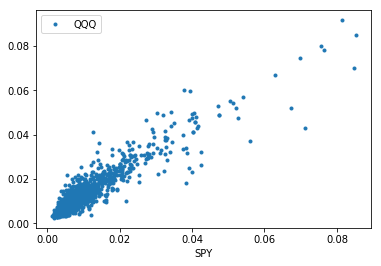

In [42]:
vola_df.plot(x='SPY', y='QQQ', style='.')

In [43]:
volume_df = pd.DataFrame({'SPY': spy_df['Volume'], 'QQQ': qqq_df['Volume'], 'XLF': xlf_df['Volume']})
volume_df.corr()

,SPY,QQQ,XLF
SPY,1.000000,0.772303,0.694013
QQQ,0.772303,1.000000,0.611255
XLF,0.694013,0.611255,1.000000


We can see that volume has significantly less correlation than volatility. So we know that volume are not very related but we now do know that when one ETF is volatile others are typically volatile as well.

### Delta Comparison

In [46]:
vola_delta_df = pd.DataFrame({'SPY': spy_df['Volatility_Delta'], 'QQQ': qqq_df['Volatility_Delta'], 'XLF': xlf_df['Volatility_Delta']})

In [47]:
vola_delta_df.corr()

,SPY,QQQ,XLF
SPY,1.000000,0.777218,0.618184
QQQ,0.777218,1.000000,0.521990
XLF,0.618184,0.521990,1.000000


In [48]:
volume_delta_df = pd.DataFrame({'SPY': spy_df['Volume_Delta'], 'QQQ': qqq_df['Volume_Delta'], 'XLF': xlf_df['Volume_Delta']})
volume_delta_df.corr()

,SPY,QQQ,XLF
SPY,1.000000,0.743028,0.614286
QQQ,0.743028,1.000000,0.523345
XLF,0.614286,0.523345,1.000000


In the case of Delta volume vs volatility the correlations are more closely related.

#### Let us see if previous day volume / volatitility of the SPY can help us predict the volume / volatitity of another ETF such as QQQ

In [66]:

qqq_volume = volume_df[['SPY', 'QQQ']]
qqq_volume['prev_spy'] = qqq_volume['SPY'].shift(1)
qqq_volume.dropna(inplace=True)
qqq_volume.describe()

,SPY,QQQ,prev_spy
count,1.258000e+03,1.258000e+03,1.258000e+03
mean,9.127041e+07,3.577389e+07,9.127036e+07
std,4.977202e+07,2.115981e+07,4.977200e+07
min,2.027000e+07,7.079300e+06,2.027000e+07
25%,5.869342e+07,2.181092e+07,5.869342e+07
50%,7.740080e+07,2.984185e+07,7.740080e+07
75%,1.057130e+08,4.184002e+07,1.056646e+08
max,3.922207e+08,1.492471e+08,3.922207e+08


In [51]:
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

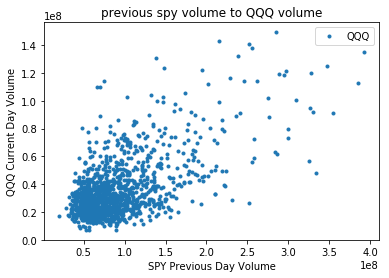

In [52]:
qqq_volume.plot(x='prev_spy', y='QQQ', style='.')
plt.title('previous spy volume to QQQ volume')  
plt.xlabel('SPY Previous Day Volume')  
plt.ylabel('QQQ Current Day Volume')  
plt.show()

In [57]:
X = qqq_volume['prev_spy'].values.reshape(-1,1)
y = qqq_volume['QQQ'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [58]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [59]:
print(regressor.intercept_)
print(regressor.coef_)

[11906285.94668199]
[[0.2595083]]


In [63]:
y_pred = regressor.predict(X_test)

eval_data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

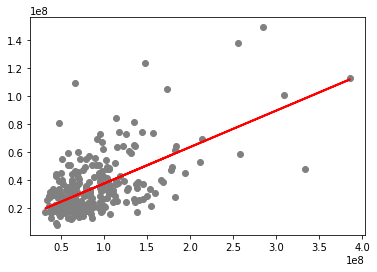

In [64]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [65]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 12263831.93573648
Mean Squared Error: 290173998748077.8
Root Mean Squared Error: 17034494.378996924
R-squared Error: 0.34226368513568917


#### Results
Looking at these results we can see the model does not do a very good job at explaing our data. Leveraging the previous day volume of the SPY does not yeild strong results for predicting tomorrows volume for the QQQ ETF. We have a very low (34%) R-squared and the MSE is very far from 0 indicating that this model is not very reliable. 

#### No lets try with volatility

In [67]:
qqq_vol = vola_df[['SPY', 'QQQ']]
qqq_vol['prev_spy'] = qqq_vol['SPY'].shift(1)
qqq_vol.dropna(inplace=True)
qqq_vol.describe()

,SPY,QQQ,prev_spy
count,1258.000000,1258.000000,1258.000000
mean,0.010714,0.013487,0.010706
std,0.009793,0.010417,0.009787
min,0.001229,0.002455,0.001229
25%,0.005059,0.006898,0.005059
50%,0.007727,0.010209,0.007727
75%,0.012443,0.016298,0.012443
max,0.085252,0.091672,0.085252


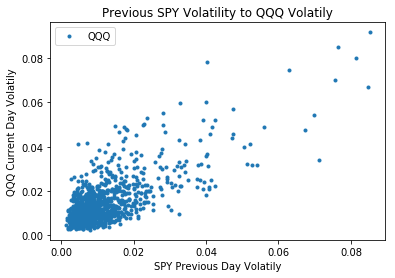

In [70]:
qqq_vol.plot(x='prev_spy', y='QQQ', style='.')
plt.title('Previous SPY Volatility to QQQ Volatily')  
plt.xlabel('SPY Previous Day Volatily')  
plt.ylabel('QQQ Current Day Volatily')  
plt.show()

In [72]:
X = qqq_vol['prev_spy'].values.reshape(-1,1)
y = qqq_vol['QQQ'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor.fit(X_train, y_train)

print(regressor.intercept_)
print(regressor.coef_)

y_pred = regressor.predict(X_test)

eval_data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

[0.00499147]
[[0.77379927]]


Mean Absolute Error: 0.005130660163259229
Mean Squared Error: 5.94580293952926e-05
Root Mean Squared Error: 0.0077109032801152815
R-squared Error: 0.4659389660836777


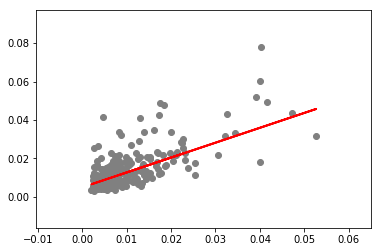

In [73]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test, y_pred))

plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

The results are slightly better than volume. We can see the R-squared Error is 46% which is better than the previous model but MSE is 5.9 which is fairly high given that the mean of all QQQ volatility is .01. This model definitely performs better but not by much. With the plot we can see the variation. 

#### Lets try a multiple regression and add in the previous day QQQ volatility and see if we can strengthen our prediction

In [75]:
qqq_vol = vola_df[['SPY', 'QQQ']]
qqq_vol['prev_spy'] = qqq_vol['SPY'].shift(1)
qqq_vol['prev_qqq'] = qqq_vol['QQQ'].shift(1)
qqq_vol.dropna(inplace=True)
qqq_vol.describe()

,SPY,QQQ,prev_spy,prev_qqq
count,1258.000000,1258.000000,1258.000000,1258.000000
mean,0.010714,0.013487,0.010706,0.013472
std,0.009793,0.010417,0.009787,0.010399
min,0.001229,0.002455,0.001229,0.002455
25%,0.005059,0.006898,0.005059,0.006898
50%,0.007727,0.010209,0.007727,0.010209
75%,0.012443,0.016298,0.012443,0.016298
max,0.085252,0.091672,0.085252,0.091672


In [77]:
X = qqq_vol[['prev_spy', 'prev_qqq']].values
y = qqq_vol['QQQ'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor.fit(X_train, y_train)

coeff_df = pd.DataFrame(regressor.coef_, ['prev_spy', 'prev_qqq'], columns=['Coefficient'])  
coeff_df



,Coefficient
prev_spy,0.494303
prev_qqq,0.284303


In [83]:
y_pred = regressor.predict(X_test)

eval_data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
eval_data.head()

,Actual,Predicted
0,0.025234,0.023518
1,0.006187,0.008966
2,0.023537,0.022622
3,0.006733,0.010882
4,0.013522,0.015545


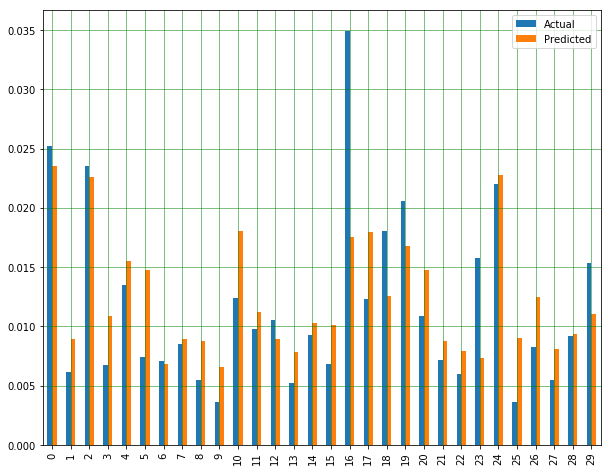

In [81]:
plot_data = eval_data.head(30)
plot_data.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [82]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.004995659330600912
Mean Squared Error: 5.738828955447182e-05
Root Mean Squared Error: 0.007575505894293253
R-squared Error: 0.4845296831082494


- The Root Mean Squared Error is .007 which is about half of the mean .013
- The algorithm was not accurate and can be confirmed unreliable

The model did increase the R-squared Error by a slight amount from 46% to 48%and the MSE did decline by .02 so this is a stronger model than the previous single regression model but not enough to consider reliable

### Going to turn attention on to stocks Tesla in particular vs  Amazon

In [101]:
tsla = {'TSLA': web.get_data_yahoo('TSLA')}
tsla_df = tsla['TSLA']

amzn = {'AMZN': web.get_data_yahoo('AMZN')}
amzn_df = amzn['AMZN']

tsla_df['Volatility'] = volatility(tsla_df)
amzn_df['Volatility'] = volatility(amzn_df)

tsla_volume_delta, tsla_vola_delta = _delta(tsla_df)
tsla_df['Volume_Delta'] = tsla_volume_delta
tsla_df['Volatility_Delta'] = tsla_vola_delta

amzn_volume_delta, amzn_vola_delta = _delta(amzn_df)
amzn_df['Volume_Delta'] = amzn_volume_delta
amzn_df['Volatility_Delta'] = amzn_vola_delta